### Import Package

In [57]:
# from rembg import remove
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy
import glob
import cv2
import os

###  Background Removal 
- I tried to use rembg package to focus on the model's blue laser, and I already done this process, if you want to try, you can uncomment the code and download the source from below link.
- source : https://github.com/danielgatis/rembg


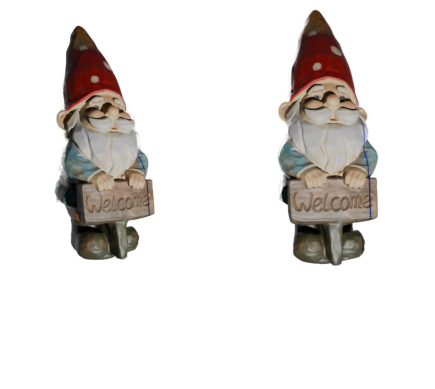

In [14]:
# # Get list of image paths matching the specified pattern
# image_paths = glob.glob('SBS images/140.jpg')

# # Define the output directory for processed images
# output_dir = 'SBS images/material'
# # Create the output directory if it doesn't exist
# os.makedirs(output_dir, exist_ok=True)

# # Process each image in the list of image paths
# for img_path in image_paths:
#     # Read the image using OpenCV
#     img = cv2.imread(img_path)
#     # Convert the image from BGR (OpenCV default) to RGB
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Remove the background using the remove function with alpha matting
#     init_bg_removed = remove(
#         img_rgb, 
#         alpha_matting=True, 
#         alpha_matting_foreground_threshold=240,  # Threshold for the foreground
#         alpha_matting_background_threshold=5,    # Threshold for the background
#         alpha_matting_erode_size=15,             # Size of erosion for alpha matting
#         alpha_matting_base_size=1000,            # Base size for the alpha matting process
#     )
    
#     # Get the base name of the image file
#     base_name = os.path.basename(img_path)
#     # Create the output path for the processed image
#     output_path = os.path.join(output_dir, base_name)
    
#     # Save the processed image
#     plt.imsave(output_path, init_bg_removed)
    
#     # Display the processed image
#     plt.imshow(init_bg_removed)
#     plt.axis('off')
#     plt.show()

###  Mask Generate
- By using BG removal images to generate a proper mask to cover up the background not we do not insterested.

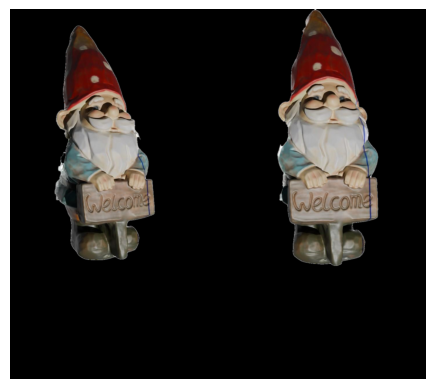

In [62]:
# Get list of image paths
image_paths = glob.glob('SBS images/material/bgremoval.jpg')

for image_path in image_paths:
    # Read and convert the image to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur and edge detection
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 20, 190)

    # Close gaps in edges with morphological operations
    kernel_close = np.ones((7, 7), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_close)

    # Find contours and create a mask
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(edges)
    cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)
    smoothed = cv2.GaussianBlur(filled, (5,5), 0)
    cv2.imwrite('SBS images/material/mask.jpg', smoothed)

    # Apply the mask to the original image
    image = cv2.imread(image_path)
    mask = cv2.imread('SBS images/material/mask.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masked_image = cv2.bitwise_and(image, mask)
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR)

# Display the final masked image
masked_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR)
plt.imshow(masked_image)
plt.axis('off')
plt.show()

###  Blue Channel Filtering
- Using two consistent images to extract blue laser

In [63]:
def find_laser(img1, img2):
    # Resize img1 to match the dimensions of img2
    img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
    # Compute absolute difference between img2 and img1
    diff = cv2.absdiff(img2, img1)
    # Resize mask to match the dimensions of diff
    mask = cv2.imread('SBS images/material/mask.jpg')
    mask = cv2.resize(mask, (diff.shape[1], diff.shape[0]))
    # Threshold the difference image
    _, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)
    # Apply morphological closing operation
    kernel = np.ones((3, 3), np.uint8)
    processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # Apply the mask to the processed image
    processed = cv2.bitwise_and(processed, mask)
    return processed

# Get list of image paths
image_paths = glob.glob('SBS images/*.jpg')
image_paths.sort()

# Define output directory for processed images
output_dir = 'SBS images/material/processed/left&right_laser'
os.makedirs(output_dir, exist_ok=True)

# Read mask image
mask = cv2.imread('SBS images/material/mask.jpg')

# Process each image in the list
num_images = len(image_paths)
for i in range(num_images):
    # Determine current and next image paths
    if i == num_images - 1:
        current_image = cv2.imread(image_paths[i])
        next_image = cv2.imread(image_paths[i-1])
    else:
        current_image = cv2.imread(image_paths[i])
        next_image = cv2.imread(image_paths[(i+1) % num_images])

    # Find laser using current and next images
    processed = find_laser(current_image, next_image)

    # Convert processed image to RGB
    processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)

    # Apply morphological opening to the processed image
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(processed, cv2.MORPH_OPEN, kernel)

    # Save the processed image
    base_name = os.path.basename(image_paths[i])
    output_path = os.path.join(output_dir, base_name)
    cv2.imwrite(output_path, processed)


###  Image Cropping

In [4]:
# Get list of image paths
image_paths = glob.glob('SBS images/material/processed/left&right_laser/*.jpg')

# Define output directories for cropped images
output_dir_left = 'SBS images/material/processed/crop/left'
output_dir_right = 'SBS images/material/processed/crop/right'
os.makedirs(output_dir_left, exist_ok=True)
os.makedirs(output_dir_right, exist_ok=True)

# Process each image in the list
for img_path in image_paths:
    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read image: {img_path}")
        continue
    
    # Convert image to RGB format
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Get image dimensions
    height, width = img_rgb.shape[:2]
    # Calculate the split position
    split_position = width // 2
    # Crop left half
    left_half = img_rgb[:, :split_position]
    # Save left half
    base_name = os.path.basename(img_path)
    output_path = os.path.join(output_dir_left, base_name)
    cv2.imwrite(output_path, cv2.cvtColor(left_half, cv2.COLOR_RGB2BGR))

    # Crop right half
    right_half = img_rgb[:, split_position:]
    # Save right half
    output_path = os.path.join(output_dir_right, base_name)
    cv2.imwrite(output_path, cv2.cvtColor(right_half, cv2.COLOR_RGB2BGR))

print("Images cropped and saved successfully.")

Images cropped and saved successfully.


### Left Laser Process
- Turn left laser into unit laser image (1 row with 1 pixel).

In [5]:
# Get list of image paths
image_paths = glob.glob('SBS images/material/processed/crop/left/*.jpg')
image_paths.sort()
num_images = len(image_paths)

# Resize all images to the maximum dimensions found
resized_images = []
max_height = 0
max_width = 0

for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is None:
        continue
    height, width, _ = img.shape
    max_height = max(max_height, height)
    max_width = max(max_width, width)
    resized_images.append(cv2.resize(img, (max_width, max_height)))

# List to store laser points for each image
points_list = []

# Process each image
for i in range(num_images):
    # Convert image to grayscale
    gray = cv2.cvtColor(resized_images[i], cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # Initialize result image
    result = np.zeros_like(blurred)

    # Background color assumption
    background_color = 0
    points = []

    # Iterate over each row of the image
    for j in range(blurred.shape[0]):
        row = blurred[j, :]
        
        # Check if the row has non-background color pixels
        if np.any(row != background_color):
            # Find the maximum value in the row
            max_val = np.max(row)
            # Find indices where the maximum value occurs
            max_indices = np.where(row == max_val)[0]
            
            # If there are multiple maxima, take the center index
            if max_indices.size > 0:
                center_idx = max_indices[len(max_indices) // 2]
                # Store the laser point (j, center_idx)
                points.append((j, center_idx))
                # Mark the result image with the laser point
                result[j, center_idx] = 255

    # Append the points for the current image to the points_list
    points_list.append(points)

### Right Laser Process
- Extract all non-zero pixel coordinate

In [6]:
# Define folder containing right laser images
image_folder_path = 'SBS images/material/processed/crop/right/*.jpg'

# Get list of image paths
image_paths = glob.glob(image_folder_path)

# List to store non-black pixel coordinates for each image
non_black_coords_list = []

# Process each image
for image_path in image_paths:
    # Read the image
    dst_image = cv2.imread(image_path)
    
    # Convert image to grayscale
    gray_image = cv2.cvtColor(dst_image, cv2.COLOR_BGR2GRAY)
    
    # Find coordinates of non-black pixels (pixel intensity > 0)
    non_black_coords = np.argwhere(gray_image > 0)
    
    # Append the coordinates to the list
    non_black_coords_list.append(non_black_coords)

# non_black_coords_list now contains a list of NumPy arrays, where each array
# contains the coordinates of non-black pixels for the corresponding image.

### Epipolar Geometry
- By projecting the points from left image to find the potential points with a distance threshold.

In [7]:
# Fundamental matrix F
F = np.array([[3.283965767647195E-7, -6.76098398189792E-6, 0.0021123144539793737],
              [-8.046341661808292E-6, 3.05632173594769E-8, 0.05124913199417346],
              [0.0048160232373805345, -0.051062699158041805, 1.0706286680443888]])

# Get list of image paths
image_paths = glob.glob('SBS images/*.jpg')

# Initialize lists to store updated left and right points
updated_left_points_list = []
updated_right_points_list = []

# Iterate over each image path
for image_path in tqdm(image_paths, desc="Processing images"):
    # Read the image
    image = cv2.imread(image_path)
    
    # Find corresponding points and non-black coordinates
    points = np.array(points_list[i])  # Assuming points_list is defined and contains the left points
    non_black_coords = np.array(non_black_coords_list[i])  # Assuming non_black_coords_list is defined and contains the non-black pixel coordinates

    # Initialize lists to store matched points
    left_points = []
    right_points = []

    # Iterate over each point in the left image
    for point in points:
        # Convert the point to homogeneous coordinates
        point_homogeneous = np.array([point[1], point[0], 1])

        # Compute the epipolar line
        epipolar_line = F @ point_homogeneous
        
        # Extract coefficients of the line
        a, b, c = epipolar_line
        
        # Get dimensions of the image
        h, w, _ = image.shape
        
        # Calculate the endpoints of the epipolar line segment
        if b != 0:
            y0 = int(-c / b)
            y1 = int(-(c + a * w) / b)
            x0, x1 = 0, w
        else:
            y0, y1 = 0, h
            x0 = int(-c / a)
            x1 = int(-(c + b * h) / a)
        
        # Set distance threshold for matching
        distance_threshold = 10
        
        # List to store potential matching points
        potential_points = []
        
        # Iterate over each non-black coordinate in the right image
        for right_point in non_black_coords:
            x, y = right_point[1], right_point[0]
            
            # Compute distance from the point to the epipolar line
            distance = abs(a * x + b * y + c) / np.sqrt(a**2 + b**2)
            
            # Check if the distance is below the threshold
            if distance < distance_threshold:
                potential_points.append([x, y])
        
        # If potential matching points were found, calculate the mean
        if len(potential_points) > 0:
            mean_point = np.mean(potential_points, axis=0).astype(int)
            left_points.append(point)
            right_points.append(mean_point)
    
    # If matching points were found for the image, append them to the lists
    if len(left_points) > 0 and len(right_points) > 0:
        updated_left_points_list.append(left_points)
        updated_right_points_list.append(right_points)

# Assertion to ensure that the number of points in left and right images are the same
assert len(updated_left_points_list[100]) == len(updated_right_points_list[100]), "The number of points in the left and right images are not the same."

Processing images:   0%|          | 0/179 [00:00<?, ?it/s]

Processing images: 100%|██████████| 179/179 [27:00<00:00,  9.05s/it]


### Scatter To Check The Selected Points

In [69]:
# Read the original image
image = cv2.imread('SBS images/080.jpg')

# Create a blank image to draw points
blank = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)

# Iterate over the updated points lists
for i in range(len(updated_left_points_list)):
    # Draw circles on the blank image for left points (green)
    for point in updated_left_points_list[i]:
        cv2.circle(blank, (point[1], point[0]), 1, (0, 255, 0), -1)
    
    # Draw circles on the blank image for right points (green)
    for point in updated_right_points_list[i]:
        cv2.circle(blank, (point[0], point[1]), 1, (0, 255, 0), -1)
    
    # Overlay the points on the original image with transparency
    alpha = 0.5
    overlay = cv2.addWeighted(image, 1 - alpha, blank, alpha, 0)
    
    # Display the image with overlaid points
    cv2.imshow('image', overlay)
    
    # Wait for 10 milliseconds
    cv2.waitKey(10)

# Wait for any key press and then close all windows
cv2.waitKey(0)
cv2.destroyAllWindows()

### Coordinate Transformation

In [70]:
# Deepcopy the updated points lists
consistent_left_points = copy.deepcopy(updated_left_points_list)
consistent_right_points = copy.deepcopy(updated_right_points_list)

# Reverse the points in consistent_left_points
for i in range(len(consistent_left_points)):
    for j in range(len(consistent_left_points[i])):
        consistent_left_points[i][j] = consistent_left_points[i][j][::-1]

# Adjust the consistent_right_points
adjusted_consistent_right_points = []
height, width, _ = image.shape

for points in consistent_right_points:
    adjusted_points = [[point[0] - width // 2, point[1]] for point in points]
    adjusted_consistent_right_points.append(adjusted_points)

# Print the first left and right points after adjustment
print("The first left point in the first image:", consistent_left_points[0][0])
print("The first right point in the first image:", adjusted_consistent_right_points[0][0])

The first left point in the first image: [199 512]
The first right point in the first image: [215, 509]


### Camera Parameters

In [71]:
# Left Camera Intrinsics
K1 = np.array([[1000.0, 0.0, 360.0],
            [0.0, 1000.0, 640.0],
            [0.0, 0.0, 1.0]], dtype=np.float32)
# Left Camera Extrinsics
RT1 = np.array([[0.88649035, -0.46274707, 0.00, -14.42428],
                [-0.070794605, -0.13562201, -0.98822814, 86.532959],
                [0.45729965, 0.8760547, -0.1529876, 235.35446]], dtype=np.float32)
P1 = K1 @ RT1
P1 = P1.astype(np.float32)
print("Projection Matrix 1:\n",P1)

# Right Camera Intrinsics
K2 = np.array([[1100.0, 0.0, 360.0],
            [0.0, 1100.0, 640.0],
            [0.0, 0.0, 1.0]], dtype=np.float32)
# Right Camera Extrinsics
RT2 = np.array([[0.98480779, -0.17364818, -4.9342116E-8, -0.98420829],
                [-0.026566068, -0.15066338, -0.98822814, 85.070221],
                [0.17160401, 0.97321475, -0.1529876, 236.97873]], dtype=np.float32)
P2 = K2 @ RT2
P2 = P2.astype(np.float32)
print("Projection Matrix 2:\n",P2)

Projection Matrix 1:
 [[ 1.0511183e+03 -1.4736737e+02 -5.5075535e+01  7.0303328e+04]
 [ 2.2187717e+02  4.2505301e+02 -1.0861403e+03  2.3715981e+05]
 [ 4.5729965e-01  8.7605470e-01 -1.5298760e-01  2.3535446e+02]]
Projection Matrix 2:
 [[ 1.1450660e+03  1.5934431e+02 -5.5075588e+01  8.4229711e+04]
 [ 8.0603889e+01  4.5712775e+02 -1.1849630e+03  2.4524362e+05]
 [ 1.7160401e-01  9.7321475e-01 -1.5298760e-01  2.3697873e+02]]


### Extract RGB From The First Image

In [72]:
'''obtain the RGB value for each point'''
image = cv2.imread('SBS images/000.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

rgb_list = []

for i in range(len(consistent_left_points)):
    point_rgb_list = []
    for point in consistent_left_points[i]:
        x, y = point
        rgb = image[y, x]
        point_rgb_list.append(rgb)
    rgb_list.append(point_rgb_list)

print(len(rgb_list))  

162


### Direct Triangulation 

In [73]:
import numpy as np

def DirectTriangulation(P1, P2, pt1, pt2):
    """
    Perform direct triangulation to compute 3D points from corresponding 2D points in two images.

    Parameters:
    - P1, P2: 3x4 projection matrices of the two cameras.
    - pt1, pt2: Lists of 2D points from the left and right images, respectively.

    Returns:
    - result: List of computed 3D points in homogeneous coordinates.
    """
    A = np.zeros((4, 4))  # Initialize the A matrix
    result = []  # List to store the computed 3D points

    # Iterate through each pair of corresponding points
    for idx, point in enumerate(pt1):
        projection_matrix = [P1, P2]
        project_points = [pt1[idx], pt2[idx]]

        # Construct the A matrix for SVD
        for i in range(2):
            x = project_points[i][0]
            y = project_points[i][1]
            for k in range(4):
                A[i][k] = x * projection_matrix[i][2][k] - projection_matrix[i][0][k]
                A[i * 2 + 1][k] = y * projection_matrix[i][2][k] - projection_matrix[i][1][k]

        # Perform Singular Value Decomposition (SVD) on A
        U, S, V = np.linalg.svd(A)
        X = V[-1]  # Take the last row of V
        X = X / X[3]  # Normalize by dividing by the fourth coordinate (homogeneous coordinates)

        result.append(X[:3])  # Append the computed 3D point to the result list

    return result


model_point_list = []  # List to store the final model points with RGB values

# Loop through each pair of images
for i in range(len(consistent_left_points)):
    # Perform direct triangulation to get 3D points
    result = DirectTriangulation(P1, P2, consistent_left_points[i], adjusted_consistent_right_points[i])
    result_np = np.array(result)  # Convert the result to numpy array

    # Filter valid 3D points within a distance threshold
    valid_result = [point for point in result_np if all(abs(coord) <= 200 for coord in point)]
    valid_result_np = np.array(valid_result)  # Convert the valid result to numpy array

    # Check if there are valid points
    if valid_result_np.size > 0:
        rgb_np = np.array(rgb_list[i][:len(valid_result)])  # Assuming rgb_list is defined and contains RGB values
        
        # Combine valid 3D points with RGB values
        valid_points3D_rgb = np.concatenate((valid_result_np, rgb_np), axis=1)
        
        # Append the combined array to model_point_list
        model_point_list.append(valid_points3D_rgb)

### Rough evaluation
- Visualize the 3D model points in program

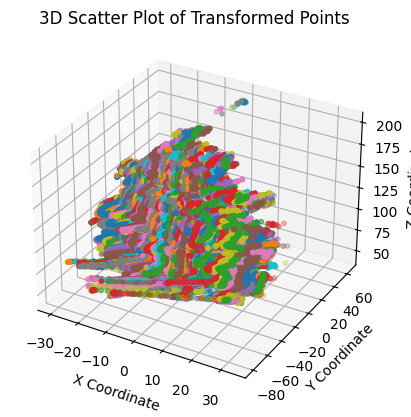

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for points_3d in model_point_list:
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=10)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Scatter Plot of Transformed Points')
plt.show()

### Model Evaluation Output
- Export xyz files with rgb and import them into meshlab for evaluating the reconstruction accuracy.

In [75]:
'''Save 3D points to .xyz file'''
with open("R12522636.txt", "w") as f:
    for points_3d in model_point_list:
        for point in points_3d:
            rgb = [round(coord) if i > 2 else coord for i, coord in enumerate(point[3:])]
            rgb = [int(coord) for coord in rgb]  
            f.write(f"{point[0]:.6f} {point[1]:.6f} {point[2]:.6f} {rgb[0]} {rgb[1]} {rgb[2]}\n")

print("3D points saved successfully.")

3D points saved successfully.
